Welcome to the world of quantitative finance!
Ray Chen======
Introduction
--
In this tutorial, we will show you how to build and simulate two portfolios using Python.  Specifically, this tutorial will cover the construction of an equal weighted and inverse volatility portfolio.  Portfolio simulation can cover signal generation, portfolio construction, and backtesting. Here we would like you to focus on building, developing and optimizing strategies and minimize the focus on the simulation/backtesting mechanics.  At the end of this tutorial, you should be able to construct a portfolio, build an equity curve, tabulate a return histogram, and produce a performance analytics table.

Minimizing backtesting mechanics
--
“Backtesting mechanics” refers to calculating each portfolio holding’s contribution and any transactions that occur during the simulation. To maintain focus on the portfolio construction phase, we will use the “bt” package for backtesting mechanics (http://pmorissette.github.io/bt/). We prefer that you follow our template when using the bt package so that we can assist if you encounter any problems.  Ideally, we will create a modular structure so that you can create other portfolios and test them using the bt package

Version
--
We plan to use python27 in Anaconda. Please install [Anaconda](https://www.anaconda.com/distribution/) and the [bt package](http://pmorissette.github.io/bt/install.html).

Importing packages
--
First of all, import all the packages we need. Please spend some time on numpy and pandas. We will use them all the time.


In [64]:
import numpy as np
import pandas as pd 
import quadprog as qp
import bt
from bt.core import Algo
import warnings
warnings.filterwarnings('ignore')

Selecting the the universe
--

The first step in portfolio simulation is selecting the universe of desired investments.  We will need the performance of each investment at the desired frequency, usually daily.  The “bt” package contains a convenient function that will pull pricing data from Yahoo Finance.  For example suppose we want to create a three holding portfolio consisting of very popular ETFs like SPY,EEM,EFA,AGG,IEF,SHY. We would create the following function:


In [65]:
data = bt.get('SPY,EEM,EFA,AGG,IEF,SHY', start='2010-01-01')
data.head(10)

,spy,eem,efa,agg,ief,shy
Date,,,,,,
2010-01-04,94.130867,35.672810,43.409443,80.810036,72.965668,77.352745
2010-01-05,94.380074,35.931736,43.447697,81.177643,73.286041,77.445839
2010-01-06,94.446495,36.006908,43.631344,81.130775,72.990295,77.455177
2010-01-07,94.845207,35.798107,43.463001,81.036865,72.990295,77.436508
2010-01-08,95.160805,36.082077,43.807339,81.083809,73.080681,77.511009
2010-01-11,95.293701,36.006908,44.166981,81.021225,73.130005,77.548286
2010-01-12,94.404961,35.430588,43.646645,81.537506,73.655685,77.613441
2010-01-13,95.202347,35.539177,44.013939,81.193336,73.302521,77.548286
2010-01-14,95.459831,35.447304,44.350624,81.404541,73.647507,77.622757


Building a portfolios
--
Next, we will show you to build two different portfolios - Equally Weighted and Inverse Volatility. We will use *Class* to ensure that characteristics or values do not inadvertently change, maintain modular construction, track inheritance, and improve readability. *Class* are part of object-oriented programming. Using *Class* in details are beyond the scope of this tutorial. For more information, please refer [here](https://en.wikipedia.org/wiki/Object-oriented_programming). We create a *Class* to calculate weights for our portfolio. Once completed, we pass our universe and the desired class to the bt package.

First we will create a *Class* for the Equally Weighted portfolio.  


In [66]:
################################################################################
# Algo Class for calculating weights
################################################################################
# Equal Weight
class WeighEqually(Algo):

    """
    Sets temp['weights'] by calculating equal weights for all items in
    selected.

    Equal weight Algo. Sets the 'weights' to 1/n for each item in 'selected'.

    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self):
        # inherit from parent class Algo is a must
        super(WeighEqually, self).__init__()

    def __call__(self, target):
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}

        return True

Class *WeighEqually* is a child class from Algo class with two methods:
1.	init: initiates itself and inherits from Algo. 
2.	call: function with input data (target) as a time-indexed data frame from pandas. Call is used to calculate each portfolio holding’s weight.
*Init* initiates the object while *call* calculates each holding’s weight.

Let's take a close look at the call function. It has two input variables - *self* refers to Class *WeighEqually* and *target* is Class *Strategy* (You will see it later). "target" contains raw pricing data, presettings, intermediate info and etc. Whenever the system needs to rebalance portfolio, it will call Class *WeighEqually* to get the weight calculated.

Next, we will create a class for the Inverse volatility weighted portfolio in a similar way.

In [67]:
class WeighInvVol(Algo):

    """
    Sets temp['weights'] based on the inverse volatility Algo.

    Sets the target weights based on ffn's calc_inv_vol_weights. This
    is a commonly used technique for risk parity portfolios. The least
    volatile elements receive the highest weight under this scheme. Weights
    are proportional to the inverse of their volatility.

    Args:
        * lookback (DateOffset): lookback period for estimating volatility

    Sets:
        * weights

    Requires:
        * selected

    """

    def __init__(self, lookback=pd.DateOffset(months=3),
                 lag=pd.DateOffset(days=0)):
        super(WeighInvVol, self).__init__()
        self.lookback = lookback
        self.lag = lag

    def __call__(self, target):
        selected = target.temp['selected']

        if len(selected) == 0:
            target.temp['weights'] = {}
            return True

        if len(selected) == 1:
            target.temp['weights'] = {selected[0]: 1.}
            return True

        t0 = target.now - self.lag
        prc = target.universe[selected].ix[t0 - self.lookback:t0]
        tw = bt.ffn.calc_inv_vol_weights(
            prc.to_returns().dropna())
        target.temp['weights'] = tw.dropna()
        return True

Compare to Equal Weight that require no prior information, the inversely weighted volatility strategy requires a “lookback” window that is used to calculate each portfolio holding’s volatility. 

Therefore *WeighInvVol* does the follows:
1. Extract the lookback period in the raw pricing data from at most 3 months ago to current (exclude current): prc = target.universe[selected].ix[t0 - self.lookback:t0]
2. Calculate returns and drop NAs:  prc.to_returns().dropna()
3. Calculate weights: tw = bt.ffn.calc_inv_vol_weights()

Running the simulation
--
At this point, we have pulled our holding’s data and created class for two portfolios. Next, we will use a bt function called “Strategy” to set all the required simulation settings. Strategy requires the following inputs:
1.	Periodicity: What period does Strategy use? daily, monthly, quarterly, etc
2.	Universe:  Does the function use all the holdings within the dataset or a subset?
3.	Portfolio class – in this case WeighEqually and WeighInvVol
4.	Rebalance: How often does Strategy rebalance the portfolio?


In [68]:
strategy = bt.Strategy('Equal Weight', 
                       [bt.algos.RunMonthly(),
                        bt.algos.SelectAll(),
                        WeighEqually(),
                        bt.algos.Rebalance()
                      ])

strategy2 = bt.Strategy('Inverse Volatility', 
                        [bt.algos.RunMonthly(),
                         bt.algos.SelectAll(),
                         WeighInvVol(),                      
                         bt.algos.Rebalance()
                      ])
    
backtesting  = bt.Backtest(strategy, data)
backtesting2 = bt.Backtest(strategy2, data)

Next we will pass each *strategy* to the bt backtest function for simulation.

In [69]:
result = bt.run(backtesting,backtesting2)

Equal Weight
0% [############################# ] 100% | ETA: 00:00:00Inverse Volatility
0% [############################# ] 100% | ETA: 00:00:00

Plot the equity curve.  
--
An equity curve is a graphical representation of the simulation through time.  For convenience, equity curves usually start at 100.

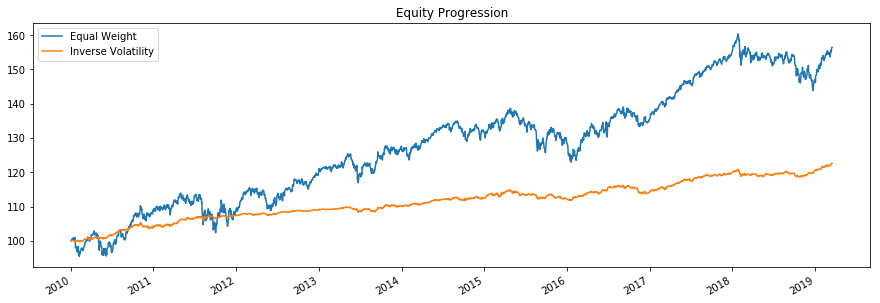

In [70]:
%matplotlib inline
result.plot()

The Equal Weight portfolio outperformed Inverse Volatility by absolute return. However Inverse Volatility portfolio experiened less risks and volatility.

Create a return histogram
--
Next step is a return histogram.  This is useful to visualize the standard deviation, skew, and kurtosis of the simulated return stream.  


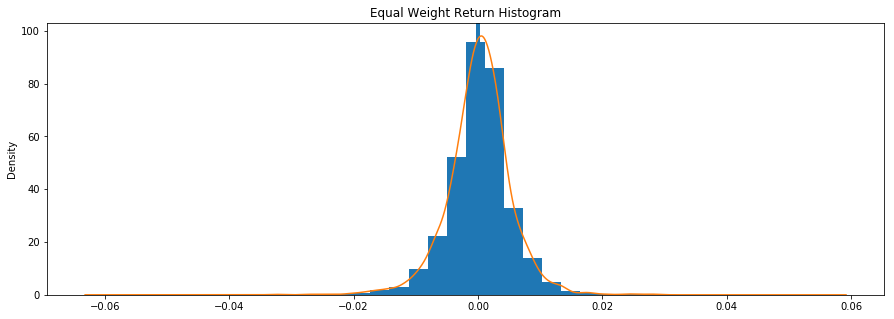

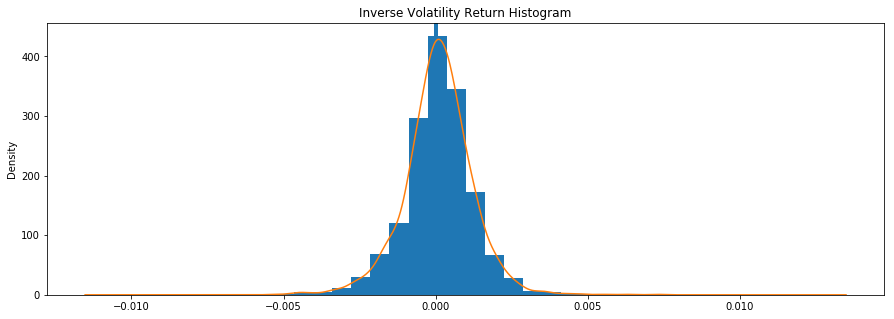

In [71]:
result[0].plot_histogram()
result[1].plot_histogram()

Performance statistics
--
Finally, we want to review the performance statistics of each simulation. Performance statistics provide multiple ways to compare portfolios by returns, risk or both.  


In [72]:
result.display()

Stat                 Equal Weight    Inverse Volatility
-------------------  --------------  --------------------
Start                2010-01-03      2010-01-03
End                  2019-03-18      2019-03-18
Risk-free rate       0.00%           0.00%

Total Return         56.42%          22.57%
Daily Sharpe         0.64            1.24
Daily Sortino        1.03            2.09
CAGR                 4.98%           2.24%
Max Drawdown         -11.33%         -2.62%
Calmar Ratio         0.44            0.85

MTD                  1.29%           0.63%
3m                   6.42%           2.19%
6m                   2.25%           2.51%
YTD                  6.46%           1.76%
1Y                   0.56%           2.64%
3Y (ann.)            5.97%           2.55%
5Y (ann.)            4.14%           2.04%
10Y (ann.)           4.98%           2.24%
Since Incep. (ann.)  4.98%           2.24%

Daily Sharpe         0.64            1.24
Daily Sortino        1.03            2.09
Daily Mean (ann.

Summary
--
At this point, you should be able to source values for your selected universe, create two portfolio construction techniques, simulate each portfolio and analyze the results.  
